<a href="https://colab.research.google.com/github/ajankowski/hotdog_or_not/blob/main/hot_dog_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning



## Import libraries

In [95]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Get the data

In [ ]:
# git clone command downloads the git repository 
# unzip extracts the data 
! git clone https://github.com/ajankowski/hotdog_or_not.git
! unzip hotdog_or_not/test.zip
! unzip hotdog_or_not/train.zip

In [22]:
# create list of images

img_list = []

for dir in os.listdir('test'):
    for file in os.listdir(os.path.join('test', dir)):
        img_list.append(os.path.join('test', dir, file))

len(img_list)

500

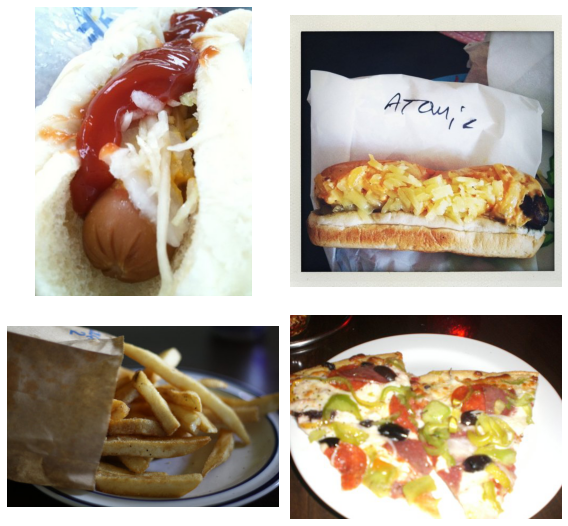

In [23]:
# sample images from the list and show it

sample_images = [img_list[i] for i in [0, 100, 300, 400]]

plt.figure(figsize=(8, 8))
for i in range(4):
   plt.subplot(2, 2, i+1)
   plt.imshow(plt.imread(sample_images[i]))
   plt.axis('off')
   plt.tight_layout()

In [24]:
# Instantiate two image generator classes:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,
    data_format='channels_last',
    rotation_range=30,
    horizontal_flip=True,
    fill_mode='reflect')

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,
    data_format='channels_last')

In [25]:
# Define the batch size:
batch_size=32

In [77]:
# Define the train and test generators: 
classes = ['hot_dog','not_hot_dog']

train_generator = train_datagen.flow_from_directory(
    directory='train',
    target_size=(224, 224),
    classes=classes,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42)

test_generator = test_datagen.flow_from_directory(
    directory='test',
    target_size=(224, 224),
    classes=classes,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42)

Found 498 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


# The model

## Load the pre-trained model

In [99]:
base_model = tf.keras.applications.vgg16.VGG16(include_top=False,
              weights='imagenet',
              input_shape=(224,224,3),
              pooling=None)

## Freeze the layers in the base (pretrained) model

In [100]:
for layer in base_model.layers:
    layer.trainable = False

## Build the neural network

In [101]:
model = tf.keras.models.Sequential()

# pretrained model
model.add(base_model)

# your own classifier 
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [102]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               3211392   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 2)                 258       
                                                                 
Total params: 17,926,338
Trainable params: 3,211,650
Non-trainable params: 14,714,688
_________________________________________________________________


## Compile the model

In [103]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Training

In [104]:
model.fit(train_generator, steps_per_epoch=15, 
                    epochs=10, validation_data=test_generator, 
                    validation_steps=15)

Epoch 1/16
15/15 [==============================] - 14s 883ms/step - loss: 2.5733 - accuracy: 0.5172 - val_loss: 1.2347 - val_accuracy: 0.5083
Epoch 2/16
15/15 [==============================] - 12s 840ms/step - loss: 0.7410 - accuracy: 0.6309 - val_loss: 0.6379 - val_accuracy: 0.5542
Epoch 3/16
15/15 [==============================] - 13s 842ms/step - loss: 0.5934 - accuracy: 0.6609 - val_loss: 0.5480 - val_accuracy: 0.7437
Epoch 4/16
15/15 [==============================] - 13s 843ms/step - loss: 0.5159 - accuracy: 0.7403 - val_loss: 0.4949 - val_accuracy: 0.7771
Epoch 5/16
15/15 [==============================] - 13s 858ms/step - loss: 0.4709 - accuracy: 0.7768 - val_loss: 0.4653 - val_accuracy: 0.7812
Epoch 6/16
15/15 [==============================] - 12s 855ms/step - loss: 0.4124 - accuracy: 0.8283 - val_loss: 0.4563 - val_accuracy: 0.7750
Epoch 7/16
15/15 [==============================] - 13s 839ms/step - loss: 0.3790 - accuracy: 0.8133 - val_loss: 0.4774 - val_accuracy: 0.7750

KeyboardInterrupt: ignored

In [ ]:
#@title Load sample images
img1_adress = "https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/delish-210326-blt-hotdog-02-landscape-jg-1622060198.jpg" #@param {type:"string"}
img2_adress = "https://s3.przepisy.pl/przepisy3ii/img/variants/800x0/pizza-grecka.jpg" #@param {type:"string"}
!wget -O test1 $img1_adress
!wget -O test2 $img2_adress

In [92]:
img_1 = tf.keras.preprocessing.image.load_img('test1', target_size=(224, 224))
img_2 = tf.keras.preprocessing.image.load_img('test2', target_size=(224, 224))

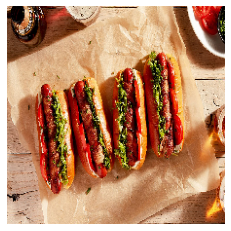

In [108]:
plt.imshow(img_1)
plt.axis('off')
plt.show()

In [109]:
pred1 = model.predict(np.expand_dims(np.array(img_1), axis=0))
pred1

array([[1., 0.]], dtype=float32)

In [110]:
classes[np.argmax(pred1)]

'hot_dog'

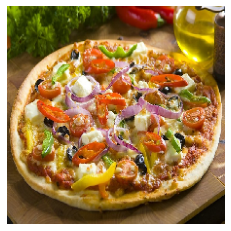

In [111]:
plt.imshow(img_2)
plt.axis('off')
plt.show()

In [112]:
pred2 = model.predict(np.expand_dims(np.array(img_2), axis=0))
pred2

array([[0., 1.]], dtype=float32)

In [113]:
classes[np.argmax(pred2)]

'not_hot_dog'

# Let's deploy it

In [115]:
!pip install gradio -q

     |████████████████████████████████| 668 kB 5.4 MB/s 
     |████████████████████████████████| 84 kB 2.6 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 2.0 MB 42.3 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 255 kB 46.5 MB/s 
     |████████████████████████████████| 211 kB 49.4 MB/s 
     |████████████████████████████████| 1.1 MB 40.5 MB/s 
     |████████████████████████████████| 271 kB 49.4 MB/s 
     |████████████████████████████████| 144 kB 41.3 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 10.9 MB 33.1 MB/s 
     |████████████████████████████████| 58 kB 5.3 MB/s 
     |████████████████████████████████| 79 kB 6.9 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 61 kB 389 kB/s 
     |████████████████████████████████| 3.6 MB 33.2 MB/s 
     |████████████████████████

In [116]:
import gradio as gr

In [121]:
def inference(image):
    img = np.expand_dims(image, axis=0)
    prediction = classes[np.argmax(model.predict(img))]
    return prediction

input = gr.inputs.Image(shape=(224, 224))

interface = gr.Interface(fn=inference, inputs=input, outputs=gr.outputs.Label())

interface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://57187.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.


(<fastapi.applications.FastAPI at 0x7fcc7a035510>,
 'http://127.0.0.1:7862/',
 'https://57187.gradio.app')